# Experiments with GloVE embeddings

To get data:

1. Run `python scripts/download_glove.py`
2. Wait for it...
3. Proceed.

In [1]:
import graph_structure as gs
import numpy as np
from tqdm import tqdm
from joblib import Parallel,delayed
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.metrics import pairwise_distances
import pandas as pd
import re

## Reading data files

In [2]:
with open('../data/questions-words.txt', 'r') as f:
    data = f.read()
print(len(data))

603955


In [3]:
# Reading analogies
titles = re.findall(':.*\n', data)
contents = re.split(':.*\n', data)

metaphors = {}
for idx, s in enumerate(titles):
    title = s.replace('\n', '').replace(': ', '').rstrip().lstrip()
    lines = contents[idx+1].split('\n')
    g1 = []
    g2 = []
    for line in lines:
        if len(line) < 5:
            continue
        #print(line)
        a, b, c, d = line.split(' ')
        if (a not in g1) and (b not in g2):
            g1.append(a)
            g2.append(b)
        if (c not in g1) and (d not in g2):
            g1.append(c)
            g2.append(d)
    metaphors[title] = [g1, g2]

In [4]:
# Load GloVe embeddings
fname = 'glove.6B.300d.txt'
def load_glove(fname):
    embed_dict = {}
    with open('../data/' + fname,'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:],'float32')
            embed_dict[word]=vector
    return embed_dict

In [5]:
def embedding_space(word_list, embed_dict):
    x = [embed_dict[w.lower()] for w in word_list]
    x = np.array(x)
    return x

In [6]:
def topology_experiment(metaphors, embed_dict, k):
    results = {}
    for category in metaphors.keys():
        g1 = metaphors[category][0]
        g2 = metaphors[category][1]
        e1 = embedding_space(g1, embed_dict)
        e2 = embedding_space(g2, embed_dict)
        if type(k)==float:
            k_ = int(k*len(metaphors[category][0]))
        else:
            k_ = k
        a = gs.mean_neighborhood_similarity_from_points(e1, e2, k_)
        results[category] = (a, len(g1))
    return results

## Topology vs. K


In [7]:
embed_dict = load_glove(fname)
print("Loaded")


Loaded


In [8]:
sg = {}

for category in tqdm(metaphors.keys()):
    sg[category] = []
    g1 = np.array(metaphors[category][0])
    g2 = np.array(metaphors[category][1])
    

    #print(choices, n_bootstrap,e1.shape, len(g1))
    e1 = embedding_space(g1, embed_dict)
    e2 = embedding_space(g2, embed_dict)
    
    ks = list(range(1, len(e1)))        
    for idx, k in enumerate(ks):
        s = gs.mean_neighborhood_similarity_from_points(e1, e2, k)
        sg[category].append(s)
    
    sg[category] = np.array(sg[category])
    

100%|██████████| 14/14 [00:01<00:00, 12.95it/s]


In [9]:
M = 1000
n = np.array(list(range(2,M)))
N = n
intersection = st.hypergeom.mean(M,n,N)
union = 2 * np.array(n) - np.array(intersection)
js = intersection/union

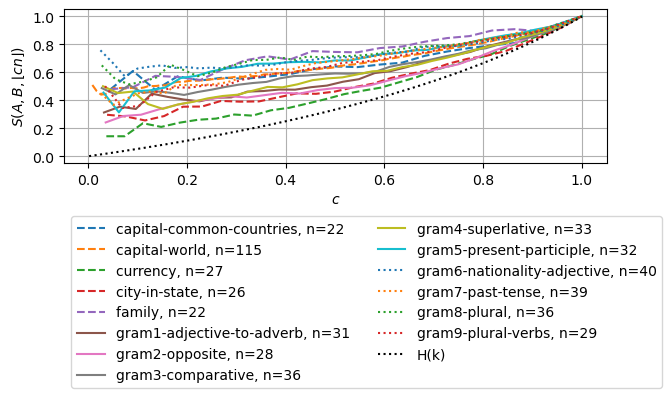

In [10]:

plt.figure(figsize=(7,2))
styles = ['--'] * 5 + ['-'] * 5 + [':'] * 5
for idx, category in enumerate(sg.keys()):
    ks = np.array(list(range(1, len(sg[category])+1)))
    xaxis = ks/ks[-1]
    plt.plot(xaxis, sg[category], label=f'{category}, n={len(sg[category])}', linestyle=styles[idx])
    #plt.fill_between(xaxis, sg[category]+2*sg_dv[category], sg[category]-2*sg_dv[category], alpha=0.5)
    
    #plt.plot(ks, sg[category],  label=f'{category}', linestyle=styles[idx])

plt.plot(n/len(n), js, 'k:', label='H(k)')    
plt.legend(ncols=2, loc='upper left', bbox_to_anchor=(0.0, -0.3))
plt.xlabel('$c$')
plt.ylabel('$S(A,B,\lfloor cn \\rfloor)$')
a = 0.2
plt.yticks(np.arange(0,1+a, a))
plt.grid()
plt.savefig('glove_similarity.pdf', bbox_inches='tight')
plt.show()

In [12]:

def analogy_experiment(metaphors, embed_dict):
    results = {}
    for category in metaphors.keys():
        g1 = metaphors[category][0]
        g2 = metaphors[category][1]
        e1 = embedding_space(g1, embed_dict)
        e2 = embedding_space(g2, embed_dict)

        acc = 0
        tries = 0        
        for i in range(len(g1)):
            for j in range(i+1, len(g1)):
                tries += 1
                w = e1[i,:] - e2[i,:] + e1[j,:]
                w = w.reshape( (1,-1))
                p = pairwise_distances(w, e2, metric='cosine')
                if np.argmin(p)==j:
                    acc += 1
        
        results[category] = (acc/tries, len(g1))
    return results

In [13]:
res = topology_experiment(metaphors, embed_dict, 0.2)
res2 = analogy_experiment(metaphors, embed_dict)

{'capital-common-countries': (0.5710144927536229, 23), 'capital-world': (0.5355700439710338, 116), 'currency': (0.2396541950113378, 28), 'city-in-state': (0.3537624926513815, 27), 'family': (0.5660455486542443, 23), 'gram1-adjective-to-adverb': (0.40508658008658005, 32), 'gram2-opposite': (0.3654898741105638, 29), 'gram3-comparative': (0.4376467376467377, 37), 'gram4-superlative': (0.369773363891011, 34), 'gram5-present-participle': (0.5580086580086578, 33), 'gram6-nationality-adjective': (0.6361665434836171, 41), 'gram7-past-tense': (0.5077100677100678, 40), 'gram8-plural': (0.6143052143052142, 37), 'gram9-plural-verbs': (0.48984126984126974, 30)}


In [25]:
results = np.array([ [res[k][0], res2[k][0]] for k in res.keys()])
labels = list(res.keys())
st.pearsonr(results[:,0],results[:,1])

PearsonRResult(statistic=0.938088573014564, pvalue=7.10868974545754e-07)

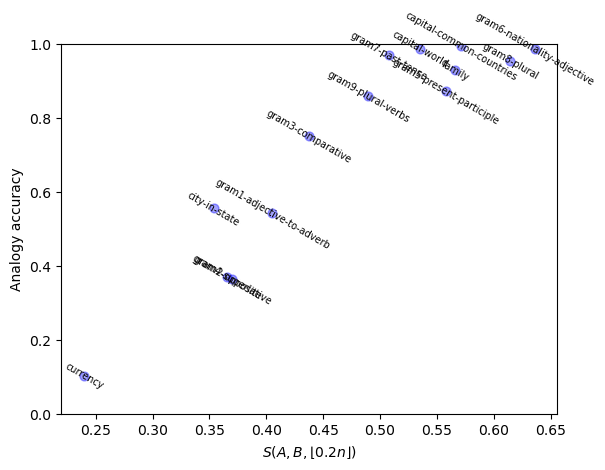

In [40]:
plt.figure()
for j in range(4):
    if j == 1 or j ==2 or j==1:
        continue
    plt.scatter(results[:,0], results[:,1], c='b', s=40, alpha=0.2)

plt.xlabel('$S(A,B,\lfloor 0.2n \\rfloor)$')
plt.ylabel('Analogy accuracy')
plt.ylim([0,1])
#plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
for idx, text in enumerate(labels):
    plt.text(results[idx,0], results[idx,1], s=text, fontsize=7, ha='center', va='center', rotation=-30)
#plt.title('GLoVe embeddings and Structural distance')
plt.savefig('glove_accuracy_similarity.pdf', bbox_inches='tight')
plt.show()